# TF-MoDISco on the Nanog GkmExplain Scores, but without MEME init

Like the TF MoDISco Nanog notebook, but lacking the MEME cluster initialization step.

In [1]:
from __future__ import print_function, division
%matplotlib inline

try:
    reload  # Python 2.7
except NameError:
    try:
        from importlib import reload  # Python 3.4+
    except ImportError:
        from imp import reload  # Python 3.0 - 3.3

In [2]:
import numpy as np
import modisco
import sys
print (sys.version)
import os

TF-MoDISco is using the TensorFlow backend.
/Users/avantishrikumar/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/avantishrikumar/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/avantishrikumar/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/a

3.7.6 (default, Jan  8 2020, 13:42:34) 
[Clang 4.0.1 (tags/RELEASE_401/final)]


/Users/avantishrikumar/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.kde module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


## Grab the input data

In [3]:
!wget https://raw.githubusercontent.com/AvantiShri/model_storage/88a1527/modisco/gkmexplain_scores/positives_test.fa.gz -O positives_test.fa.gz
!gunzip -f positives_test.fa.gz 
!wget https://raw.githubusercontent.com/AvantiShri/model_storage/88a1527/modisco/gkmexplain_scores/gkmexplain_positives_hypimpscores.txt.gz -O gkmexplain_positives_hypimpscores.txt.gz
!gunzip -f gkmexplain_positives_hypimpscores.txt.gz
!wget https://raw.githubusercontent.com/AvantiShri/model_storage/88a1527/modisco/gkmexplain_scores/gkmexplain_dnshuff_hypimpscores.txt.gz -O gkmexplain_dnshuff_hypimpscores.txt.gz
!gunzip -f gkmexplain_dnshuff_hypimpscores.txt.gz
!wget https://raw.githubusercontent.com/AvantiShri/model_storage/88a1527/modisco/gkmexplain_scores/dnshuff_seqs.fa.gz -O dnshuff_seqs.fa.gz
!gunzip -f dnshuff_seqs.fa.gz

--2020-04-27 04:09:55--  https://raw.githubusercontent.com/AvantiShri/model_storage/88a1527/modisco/gkmexplain_scores/positives_test.fa.gz
Resolving raw.githubusercontent.com... 151.101.40.133
Connecting to raw.githubusercontent.com|151.101.40.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 75038 (73K) [application/octet-stream]
Saving to: 'positives_test.fa.gz'

100%[======================================>] 75,038      --.-K/s   in 0.03s   

2020-04-27 04:09:56 (2.30 MB/s) - 'positives_test.fa.gz' saved [75038/75038]

--2020-04-27 04:09:56--  https://raw.githubusercontent.com/AvantiShri/model_storage/88a1527/modisco/gkmexplain_scores/gkmexplain_positives_hypimpscores.txt.gz
Resolving raw.githubusercontent.com... 151.101.40.133
Connecting to raw.githubusercontent.com|151.101.40.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3191036 (3.0M) [application/octet-stream]
Saving to: 'gkmexplain_positives_hypimpscores.txt.gz'

100%[=

### Read in the one-hot encoded sequences and scores

In [4]:
import numpy as np

def one_hot_encode_along_channel_axis(sequence):
    to_return = np.zeros((len(sequence),4), dtype=np.int8)
    seq_to_one_hot_fill_in_array(zeros_array=to_return,
                                 sequence=sequence, one_hot_axis=1)
    return to_return

def seq_to_one_hot_fill_in_array(zeros_array, sequence, one_hot_axis):
    assert one_hot_axis==0 or one_hot_axis==1
    if (one_hot_axis==0):
        assert zeros_array.shape[1] == len(sequence)
    elif (one_hot_axis==1): 
        assert zeros_array.shape[0] == len(sequence)
    #will mutate zeros_array
    for (i,char) in enumerate(sequence):
        if (char=="A" or char=="a"):
            char_idx = 0
        elif (char=="C" or char=="c"):
            char_idx = 1
        elif (char=="G" or char=="g"):
            char_idx = 2
        elif (char=="T" or char=="t"):
            char_idx = 3
        elif (char=="N" or char=="n"):
            continue #leave that pos as all 0's
        else:
            raise RuntimeError("Unsupported character: "+str(char))
        if (one_hot_axis==0):
            zeros_array[char_idx,i] = 1
        elif (one_hot_axis==1):
            zeros_array[i,char_idx] = 1


def read_in_seqs_and_scores(fa_file, hypimpscores_file):
    seqs = [x.rstrip() for (i,x) in enumerate(open(fa_file)) if i%2==1]
    #filter out any sequences that contain 'N's
    onehot_data = [np.array(one_hot_encode_along_channel_axis(x))
                   for x in seqs if ('N' not in x)]
    #read in the hypothetical importance scores,
    # filter out any sequences that contain 'N's
    unnorm_hyp_impscores = [w[0] for w in zip([
        np.array( [[float(z) for z in y.split(",")]
            for y in x.rstrip().split("\t")[2].split(";")])
        for x in open(hypimpscores_file)],seqs)
        if 'N' not in w[1]]
    #in the original GkmExplain paper, a normalization of the
    # importance scores and hypothetical importance scores was
    # proposed, as this was empirically observed to improve
    # the signal-to-noise ratio. Here, I will do a
    # similar-in-spirit normalization that also appears to
    # improve the signal-to-noise ratio, but which is more
    # intuitive and better-motivated than the normalization
    # from the gkmexplain paper (the reason I didn't propose it
    # in that paper is simply that I hadn't considered it).
    #The normalization consists of subtracting the mean
    # hypothetical importance across ACGT at each position such
    # that the sum of the hypothetical importance at each position
    # is 0. The intuition is that this highlights the impact of
    # each base on the output **relative to the other bases that
    # could have been present**. The normalized actual importance
    # is simply the normalized hypothetical importance multiplied
    # by the one-hot encoding.
    hyp_impscores = [x - np.mean(x, axis=-1)[:,None] for x in unnorm_hyp_impscores]
    impscores = [x*y for x,y in zip(hyp_impscores, onehot_data)]
    
    return onehot_data, hyp_impscores, impscores
    

onehot_data, hyp_impscores, impscores = read_in_seqs_and_scores(
    fa_file="positives_test.fa",
    hypimpscores_file="gkmexplain_positives_hypimpscores.txt")
print("Num onehot sequences:",len(onehot_data))

_, _, nulldist_impscores = read_in_seqs_and_scores(
    fa_file="dnshuff_seqs.fa",
    hypimpscores_file="gkmexplain_dnshuff_hypimpscores.txt")
nulldist_perposimp = np.sum(nulldist_impscores, axis=-1)

Num onehot sequences: 960


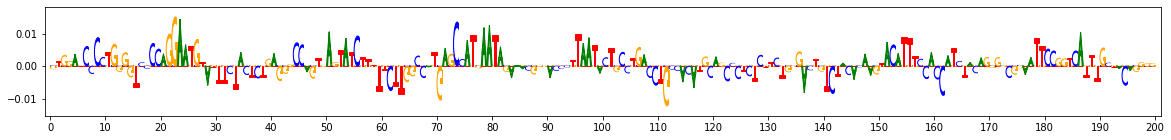

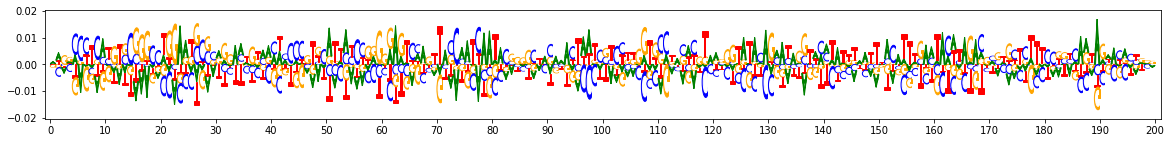

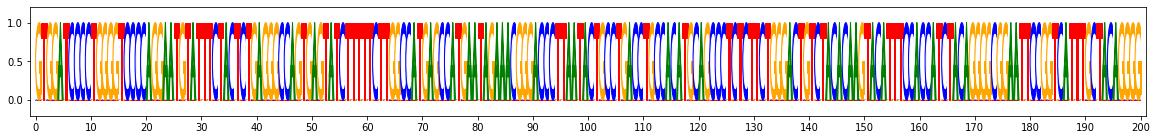

In [5]:
from matplotlib import pyplot as plt
import modisco.visualization
from modisco.visualization import viz_sequence

viz_sequence.plot_weights(impscores[0], subticks_frequency=10)
viz_sequence.plot_weights(hyp_impscores[0], subticks_frequency=10)
viz_sequence.plot_weights(onehot_data[0], subticks_frequency=10)


## Run TF-MoDISco

MEMORY 0.325136384
On task task0
Computing windowed sums on original
Generating null dist
Computing threshold


TF-MoDISco is using the TensorFlow backend.


Thresholds from null dist were -0.21752344639999993  and  0.13906743924999995
Final raw thresholds are -0.21752344639999993  and  0.13906743924999995
Final transformed thresholds are -0.9723900462962963  and  0.8939699074074074


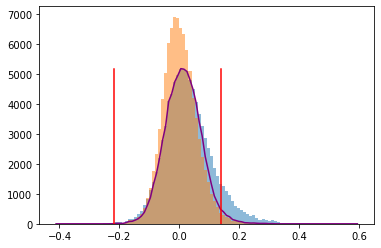

Got 1106 coords
After resolving overlaps, got 1106 seqlets
Across all tasks, the weakest transformed threshold used was: 0.8938699074074075
MEMORY 0.343560192
1106 identified in total
1 activity patterns with support >= 100 out of 3 possible patterns
Metacluster sizes:  [1086]
Idx to activities:  {0: '1'}
MEMORY 0.343588864
On metacluster 0
Metacluster size 1086
Relevant tasks:  ('task0',)
Relevant signs:  (1,)

TfModiscoSeqletsToPatternsFactory: seed=1234
(Round 1) num seqlets: 1086
(Round 1) Computing coarse affmat
MEMORY 0.33683456
Beginning embedding computation
Computing embeddings






Using TensorFlow backend.


Finished embedding computation in 6.8 s
Starting affinity matrix computations
Normalization computed in 0.1 s
Cosine similarity mat computed in 0.18 s
Normalization computed in 0.09 s
Cosine similarity mat computed in 0.16 s
Finished affinity matrix computations in 0.35 s
(Round 1) Compute nearest neighbors from coarse affmat
MEMORY 0.646172672
Computed nearest neighbors in 0.16 s
MEMORY 0.656191488
(Round 1) Computing affinity matrix on nearest neighbors
MEMORY 0.656191488
Launching nearest neighbors affmat calculation job
MEMORY 0.675487744
Parallel runs completed
MEMORY 0.553029632
Job completed in: 21.32 s
MEMORY 0.553033728
Launching nearest neighbors affmat calculation job
MEMORY 0.551718912
Parallel runs completed
MEMORY 0.553357312
Job completed in: 24.02 s
MEMORY 0.562794496
(Round 1) Computed affinity matrix on nearest neighbors in 45.67 s
MEMORY 0.565489664
Filtered down to 1016 of 1086
(Round 1) Retained 1016 rows out of 1086 after filtering
MEMORY 0.565665792
(Round 1) Com

  0%|          | 0/50 [00:00<?, ?it/s]

Quality: 0.648801404659127


  4%|▍         | 2/50 [00:00<00:20,  2.40it/s]

Quality: 0.6504817905119097


 10%|█         | 5/50 [00:01<00:16,  2.73it/s]

Quality: 0.6509328206716426


 84%|████████▍ | 42/50 [00:11<00:02,  3.11it/s]

Quality: 0.6510499005473895


100%|██████████| 50/50 [00:13<00:00,  3.62it/s]

Got 10 clusters after round 1
Counts:
{2: 167, 4: 86, 3: 95, 0: 272, 5: 77, 8: 30, 6: 32, 1: 215, 9: 12, 7: 30}
MEMORY 0.538591232
(Round 1) Aggregating seqlets in each cluster
MEMORY 0.538591232
Aggregating for cluster 0 with 272 seqlets
MEMORY 0.538591232


Trimmed 20 out of 272
Skipped 33 seqlets
Aggregating for cluster 1 with 215 seqlets
MEMORY 0.538595328
Trimmed 5 out of 215
Skipped 29 seqlets
Aggregating for cluster 2 with 167 seqlets
MEMORY 0.538595328
Trimmed 18 out of 167
Skipped 25 seqlets
Aggregating for cluster 3 with 95 seqlets
MEMORY 0.538595328
Trimmed 7 out of 95
Skipped 20 seqlets
Aggregating for cluster 4 with 86 seqlets
MEMORY 0.538599424
Trimmed 3 out of 86
Skipped 16 seqlets
Aggregating for cluster 5 with 77 seqlets
MEMORY 0.538599424
Trimmed 2 out of 77
Skipped 15 seqlets
Aggregating for cluster 6 with 32 seqlets
MEMORY 0.538599424
Trimmed 0 out of 32
Skipped 9 seqlets
Aggregating for cluster 7 with 30 seqlets
MEMORY 0.538599424
Trimmed 0 out of 30
Skipped 6 seqlets
Aggregating for cluster 8 with 30 seqlets
MEMORY 0.538599424
Trimmed 0 out of 30
Skipped 3 seqlets
Aggregating for cluster 9 with 12 seqlets
MEMORY 0.538599424
Trimmed 0 out of 12
Skipped 2 seqlets
(Round 2) num seqlets: 803
(Round 2) Computing coarse affm

  0%|          | 0/50 [00:00<?, ?it/s]

Quality: 0.5998645704915962


  2%|▏         | 1/50 [00:00<00:14,  3.27it/s]

Quality: 0.6025060748137089


  4%|▍         | 2/50 [00:00<00:13,  3.49it/s]

Quality: 0.6037774440043063


100%|██████████| 50/50 [00:10<00:00,  4.60it/s]

Got 10 clusters after round 2
Counts:
{0: 237, 1: 179, 5: 29, 2: 118, 7: 9, 6: 16, 4: 86, 8: 9, 3: 118, 9: 2}
MEMORY 0.578940928
(Round 2) Aggregating seqlets in each cluster
MEMORY 0.578940928
Aggregating for cluster 0 with 237 seqlets
MEMORY 0.578940928


Trimmed 34 out of 237
Aggregating for cluster 1 with 179 seqlets
MEMORY 0.578940928
Trimmed 42 out of 179
Aggregating for cluster 2 with 118 seqlets
MEMORY 0.578940928
Trimmed 6 out of 118
Skipped 6 seqlets
Aggregating for cluster 3 with 118 seqlets
MEMORY 0.578940928
Trimmed 6 out of 118
Skipped 3 seqlets
Aggregating for cluster 4 with 86 seqlets
MEMORY 0.578940928
Trimmed 22 out of 86
Aggregating for cluster 5 with 29 seqlets
MEMORY 0.578940928
Trimmed 6 out of 29
Removed 1 duplicate seqlets
Aggregating for cluster 6 with 16 seqlets
MEMORY 0.578940928
Trimmed 0 out of 16
Skipped 1 seqlets
Removed 1 duplicate seqlets
Aggregating for cluster 7 with 9 seqlets
MEMORY 0.578940928
Trimmed 0 out of 9
Removed 1 duplicate seqlets
Aggregating for cluster 8 with 9 seqlets
MEMORY 0.578940928
Trimmed 0 out of 9
Aggregating for cluster 9 with 2 seqlets
MEMORY 0.578940928
Trimmed 0 out of 2
Removed 1 duplicate seqlets
Got 10 clusters
Splitting into subclusters...
MEMORY 0.578854912
Inspecting for s

In [6]:
import h5py
import numpy as np
%matplotlib inline
import modisco
reload(modisco)
import modisco.backend
reload(modisco.backend.tensorflow_backend)
reload(modisco.backend)
import modisco.nearest_neighbors
reload(modisco.nearest_neighbors)
import modisco.affinitymat
reload(modisco.affinitymat.core)
reload(modisco.affinitymat.transformers)
import modisco.tfmodisco_workflow.seqlets_to_patterns
reload(modisco.tfmodisco_workflow.seqlets_to_patterns)
import modisco.tfmodisco_workflow.workflow
reload(modisco.tfmodisco_workflow.workflow)
import modisco.tfmodisco_workflow
reload(modisco.tfmodisco_workflow)
import modisco.aggregator
reload(modisco.aggregator)
import modisco.cluster
reload(modisco.cluster.core)
reload(modisco.cluster.phenograph.core)
reload(modisco.cluster.phenograph.cluster)
import modisco.value_provider
reload(modisco.value_provider)
import modisco.core
reload(modisco.core)
import modisco.coordproducers
reload(modisco.coordproducers)
import modisco.metaclusterers
reload(modisco.metaclusterers)
import modisco.clusterinit.memeinit
reload(modisco.clusterinit.memeinit)

tfmodisco_results = modisco.tfmodisco_workflow.workflow.TfModiscoWorkflow(
            target_seqlet_fdr=0.25,
            seqlets_to_patterns_factory=
                modisco.tfmodisco_workflow.seqlets_to_patterns.TfModiscoSeqletsToPatternsFactory(
                    use_louvain=False,
                    #Adjust trim_to_window_size and initial_flank_to_add
                    # according to how big you expect
                    # the core motif to be; default value is 10
                    #trim_to_window_size=6,
                    #initial_flank_to_add=2,
                    #final_flank_to_add=5,
                    #kmer_len, num_gaps and num_mismatches are used to
                    # derive kmer embeddings for coarse-grained affinity
                    # matrix calculation. kmer_len=6, num_gaps=1
                    # and num_mismatches=0 means
                    # that kmer embeddings using 6-mers with 1 gap will be
                    # used.
                    kmer_len=6, num_gaps=1,
                    num_mismatches=0,
                    final_min_cluster_size=20
            ),
       )(
    #There is only one task, so we just call this 'task0'
    task_names=["task0"],
    contrib_scores={'task0': impscores},                
    hypothetical_contribs={'task0': hyp_impscores},
    one_hot=onehot_data,
    null_per_pos_scores={'task0': nulldist_perposimp})

## Save and print the results

In [7]:
import h5py
import modisco.util
reload(modisco.util)
!rm results.hdf5
grp = h5py.File("results.hdf5")
tfmodisco_results.save_hdf5(grp)

Metaclusters heatmap


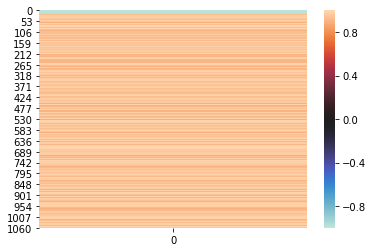

metacluster_0
activity pattern: [1]
metacluster_0 pattern_0
total seqlets: 201
Hypothetical scores:


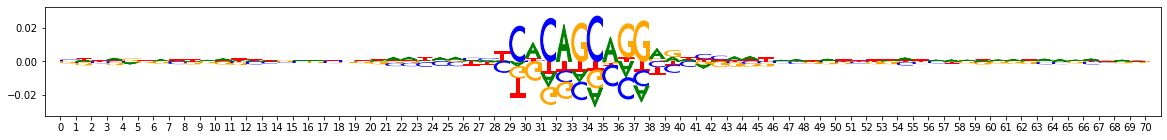

Actual importance scores:


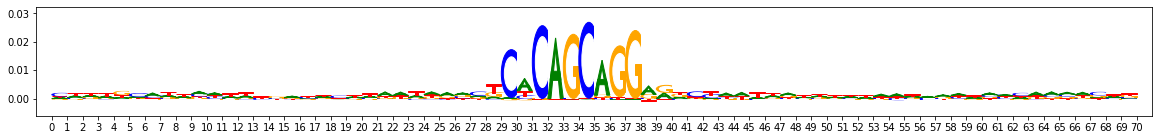

onehot, fwd and rev:


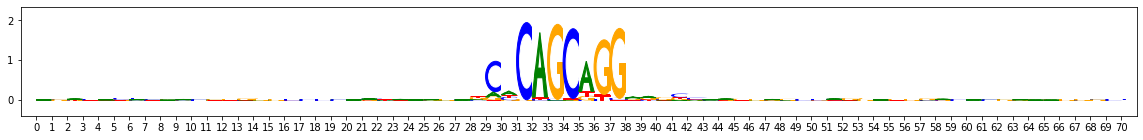

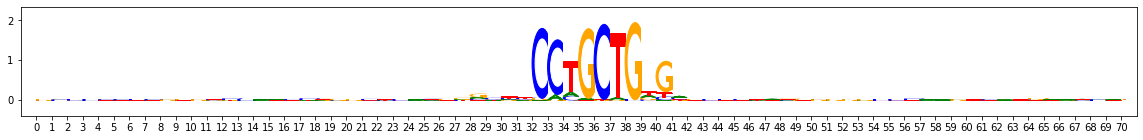

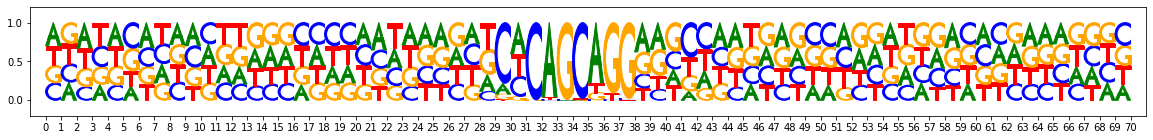

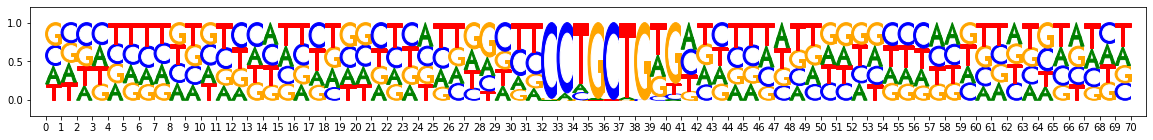

metacluster_0 pattern_1
total seqlets: 183
Hypothetical scores:


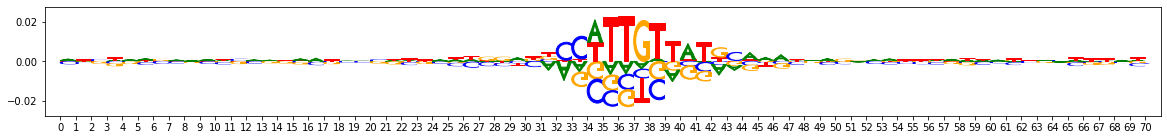

Actual importance scores:


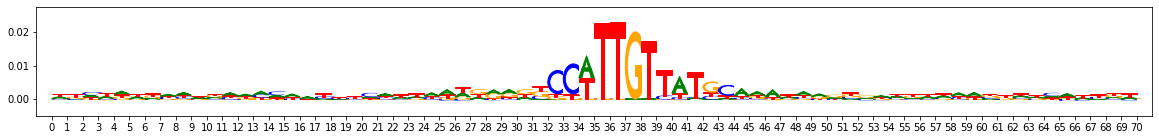

onehot, fwd and rev:


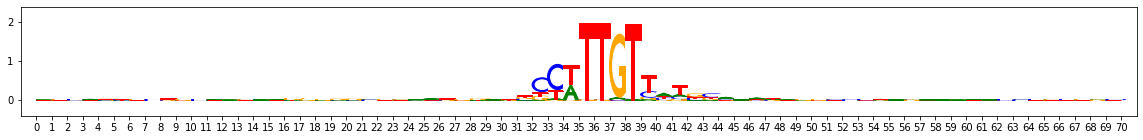

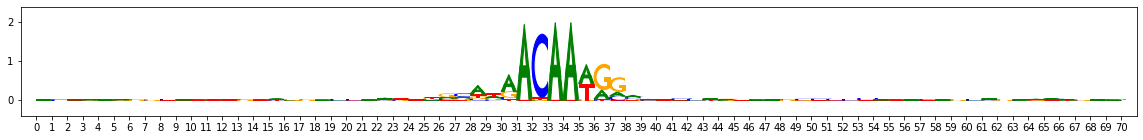

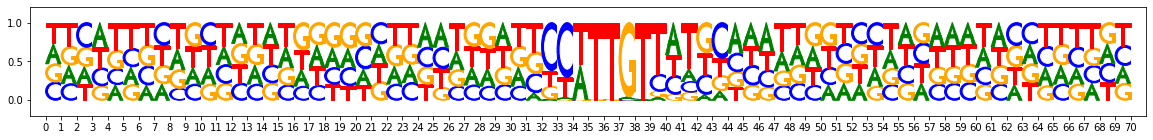

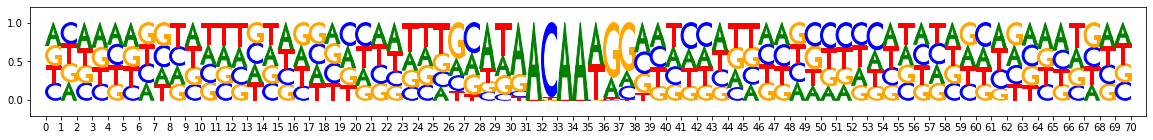

metacluster_0 pattern_2
total seqlets: 113
Hypothetical scores:


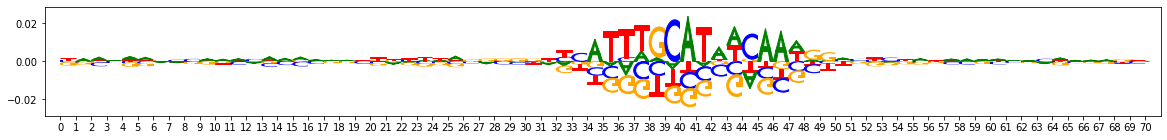

Actual importance scores:


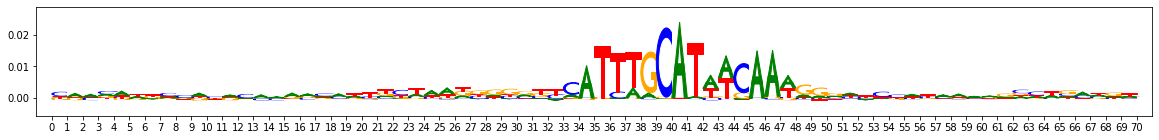

onehot, fwd and rev:


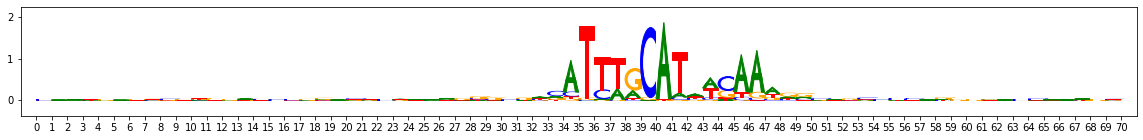

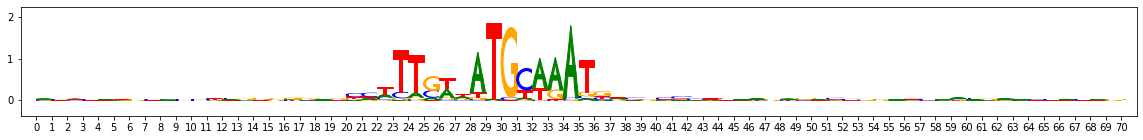

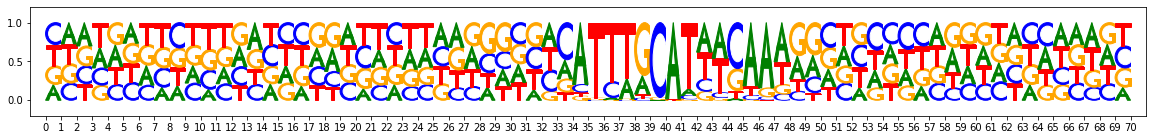

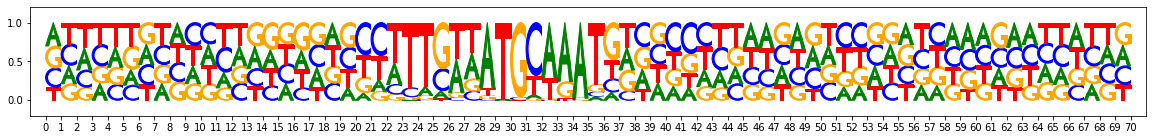

metacluster_0 pattern_3
total seqlets: 49
Hypothetical scores:


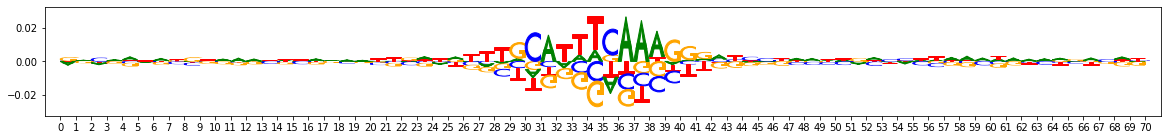

Actual importance scores:


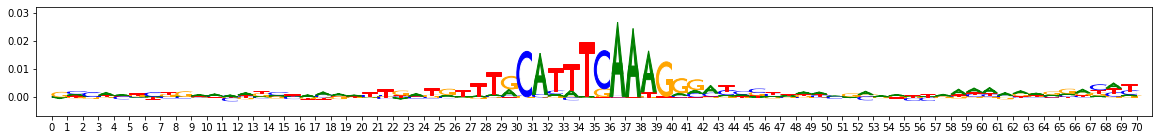

onehot, fwd and rev:


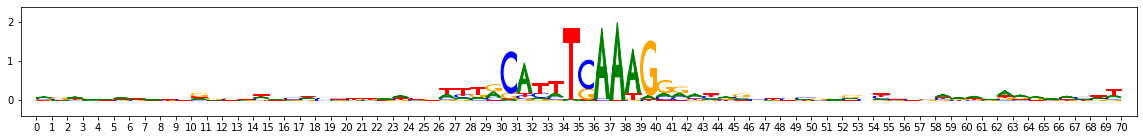

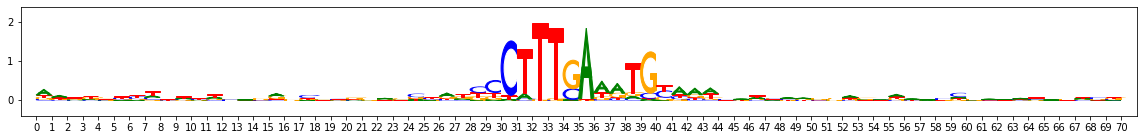

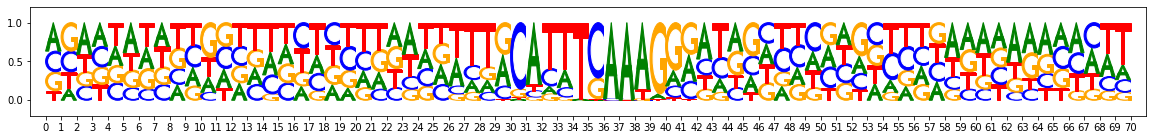

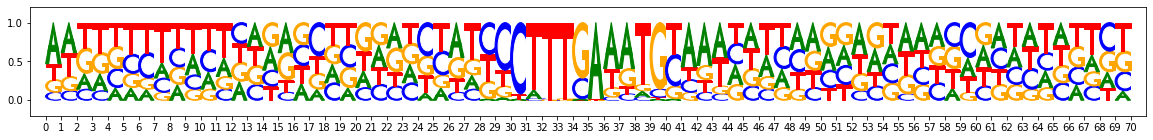

metacluster_0 pattern_4
total seqlets: 39
Hypothetical scores:


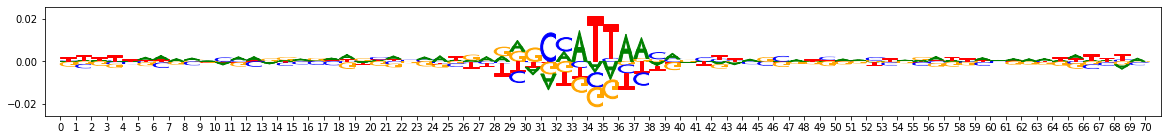

Actual importance scores:


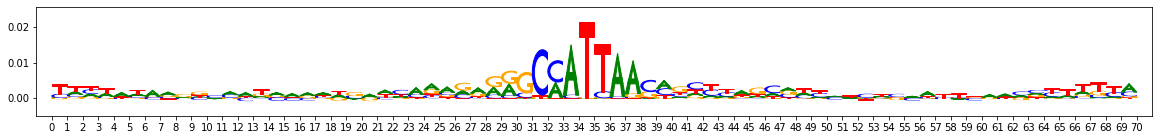

onehot, fwd and rev:


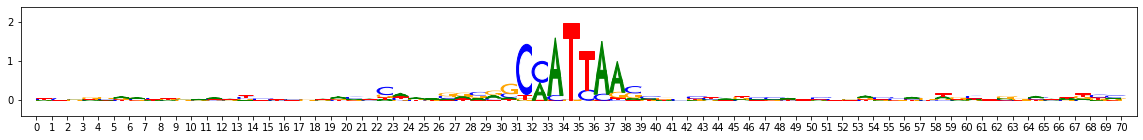

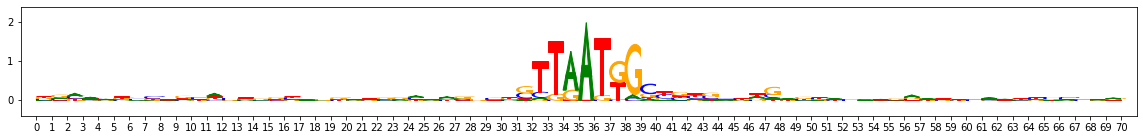

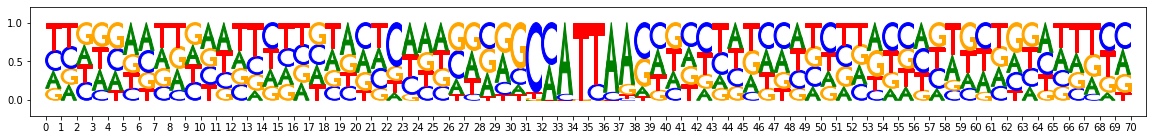

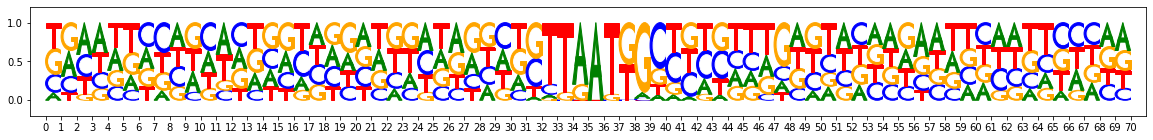

metacluster_0 pattern_5
total seqlets: 26
Hypothetical scores:


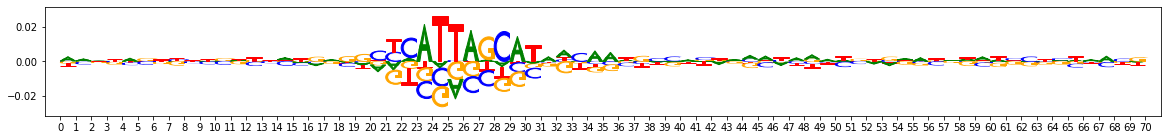

Actual importance scores:


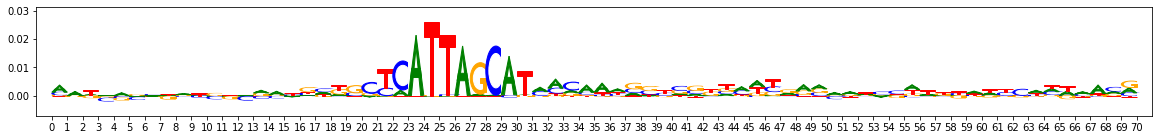

onehot, fwd and rev:


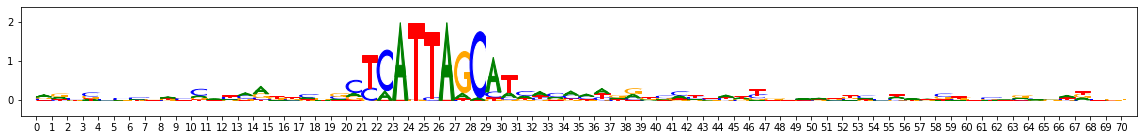

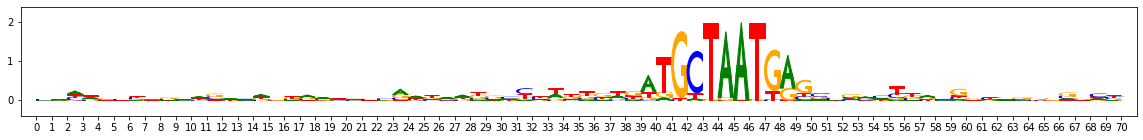

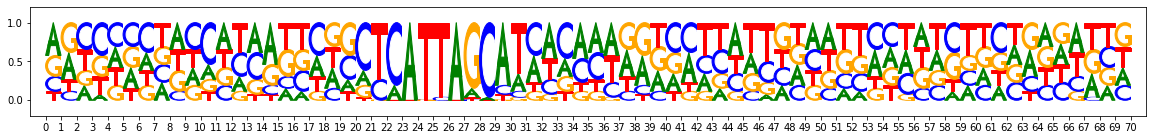

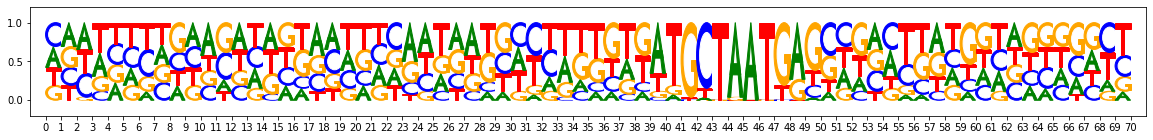

In [8]:
from collections import Counter
from modisco.visualization import viz_sequence
reload(viz_sequence)
from matplotlib import pyplot as plt

import modisco.affinitymat.core
reload(modisco.affinitymat.core)
import modisco.cluster.phenograph.core
reload(modisco.cluster.phenograph.core)
import modisco.cluster.phenograph.cluster
reload(modisco.cluster.phenograph.cluster)
import modisco.cluster.core
reload(modisco.cluster.core)
import modisco.aggregator
reload(modisco.aggregator)

hdf5_results = h5py.File("results.hdf5","r")

print("Metaclusters heatmap")
import seaborn as sns
activity_patterns = np.array(hdf5_results['metaclustering_results']['attribute_vectors'])[
                    np.array(
        [x[0] for x in sorted(
                enumerate(hdf5_results['metaclustering_results']['metacluster_indices']),
               key=lambda x: x[1])])]
sns.heatmap(activity_patterns, center=0)
plt.show()

metacluster_names = [
    x.decode("utf-8") for x in 
    list(hdf5_results["metaclustering_results"]
         ["all_metacluster_names"][:])]

all_patterns = []

for metacluster_name in metacluster_names:
    print(metacluster_name)
    metacluster_grp = (hdf5_results["metacluster_idx_to_submetacluster_results"]
                                   [metacluster_name])
    print("activity pattern:",metacluster_grp["activity_pattern"][:])
    all_pattern_names = [x.decode("utf-8") for x in 
                         list(metacluster_grp["seqlets_to_patterns_result"]
                                             ["patterns"]["all_pattern_names"][:])]
    if (len(all_pattern_names)==0):
        print("No motifs found for this activity pattern")
    for pattern_name in all_pattern_names:
        print(metacluster_name, pattern_name)
        all_patterns.append((metacluster_name, pattern_name))
        pattern = metacluster_grp["seqlets_to_patterns_result"]["patterns"][pattern_name]
        print("total seqlets:",len(pattern["seqlets_and_alnmts"]["seqlets"]))
        background = np.array([0.27, 0.23, 0.23, 0.27])
        print("Hypothetical scores:")
        viz_sequence.plot_weights(pattern["task0_hypothetical_contribs"]["fwd"])
        print("Actual importance scores:")
        viz_sequence.plot_weights(pattern["task0_contrib_scores"]["fwd"])
        print("onehot, fwd and rev:")
        viz_sequence.plot_weights(viz_sequence.ic_scale(np.array(pattern["sequence"]["fwd"]),
                                                        background=background)) 
        viz_sequence.plot_weights(viz_sequence.ic_scale(np.array(pattern["sequence"]["rev"]),
                                                        background=background))
        viz_sequence.plot_weights(pattern["sequence"]["fwd"]) 
        viz_sequence.plot_weights(pattern["sequence"]["rev"]) 
        
hdf5_results.close()